116083

## **Techniques and Algorithms in Data Science - FGV EMAp**

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDRegressor, ElasticNet, Lasso
from fast_ml.model_development import train_valid_test_split

### **Part 1**: Data Loading and preprocessing

**a)** Load the data into a pandas DataFrame.

In [16]:
diamonds = pd.read_csv('diamonds.csv')

In [17]:
diamonds.size

539400

**b)** Clean the dataset by removing datapoints with missing values and datapoints that are repeated.

In [18]:
diamonds = diamonds.dropna()            # drop rows with missing values
diamonds = diamonds.drop_duplicates()   # drop duplicate rows

In [19]:
diamonds.size

537940

**c)** For each feature in the dataset, make a figure containing 2 subplots showing:
- The histogram of the values of the feature (all classes combined);
- The histogram of the values of the feature separately for each class, when using the “cut” column as the class identifier. Use a different color for each class.

Note that all your histograms should have 50 bins and should be normalized (the area under the histogram should sum up to 1).

In [20]:
flt = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z'] # list of columns to plot

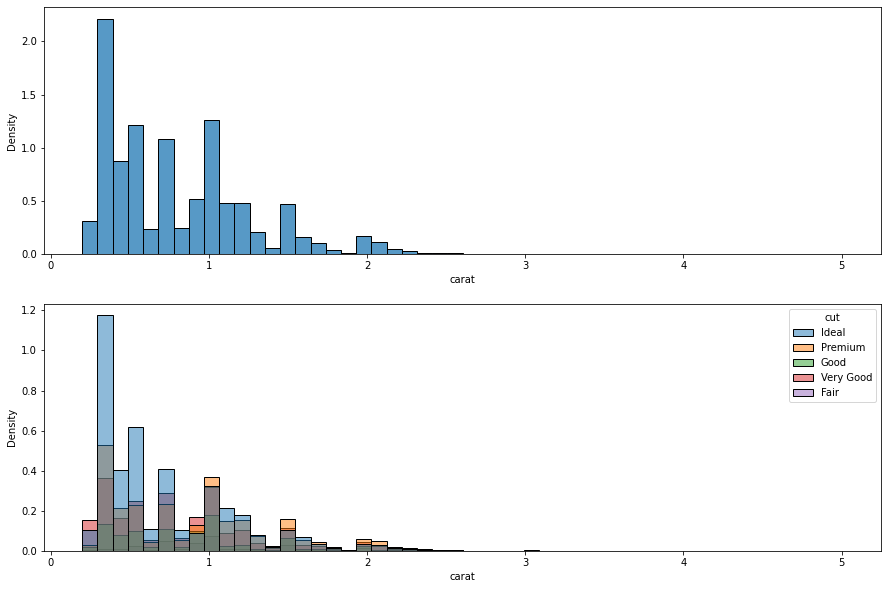

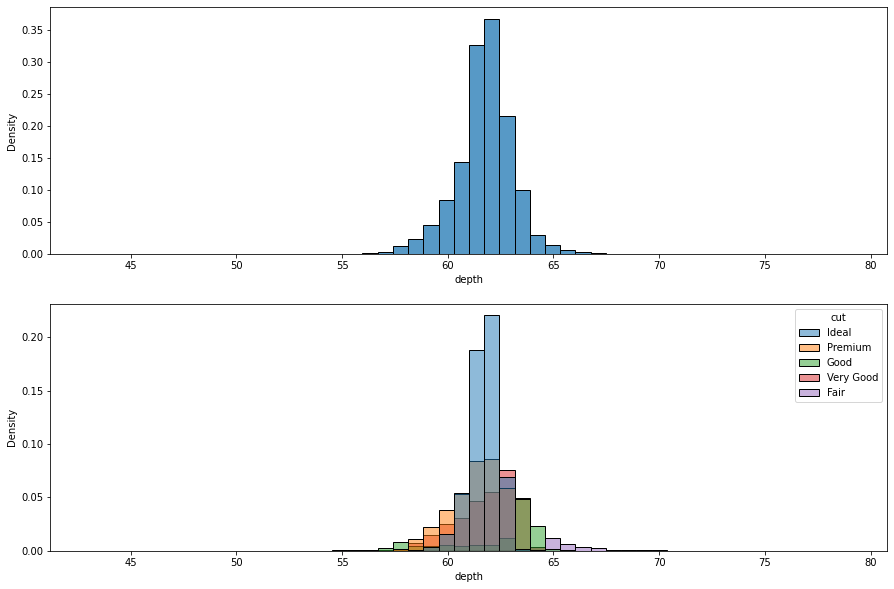

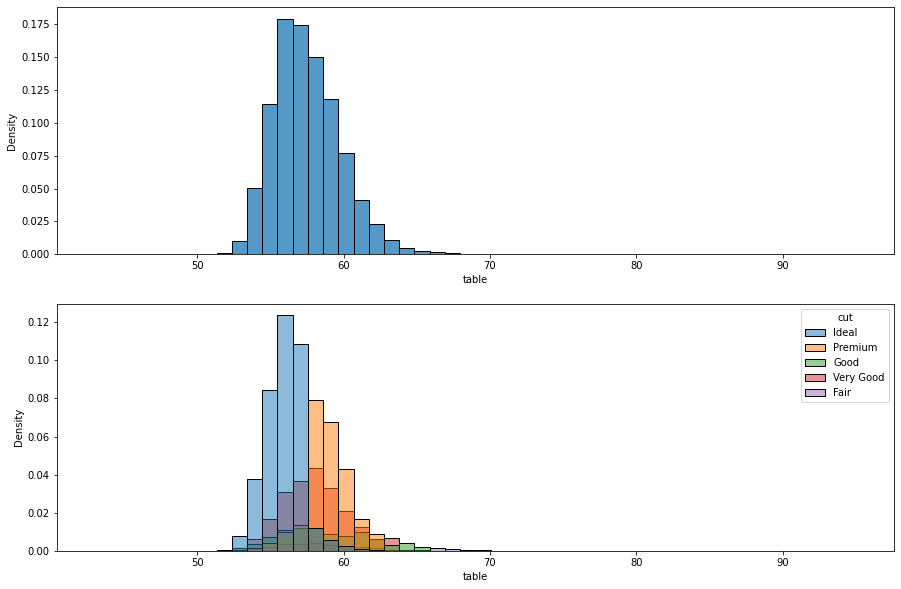

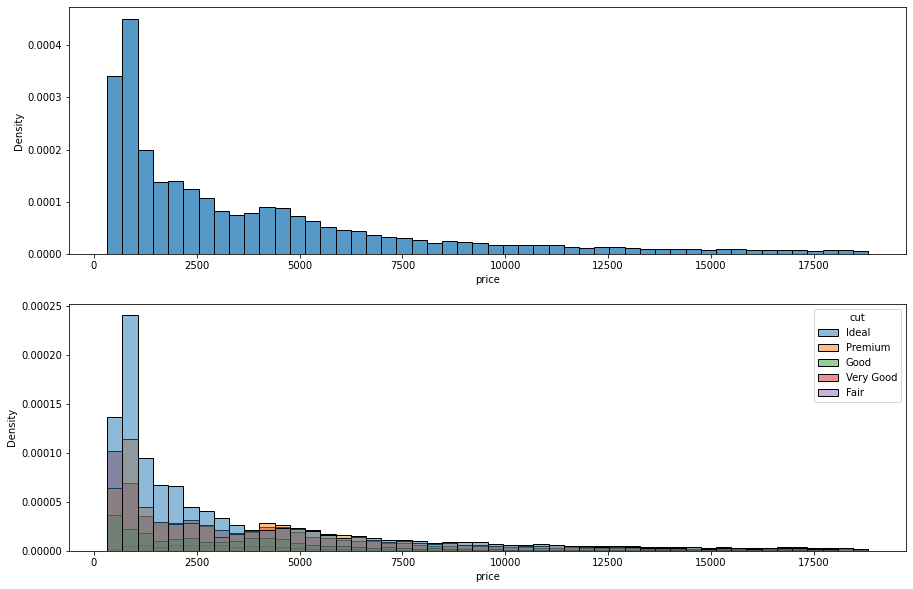

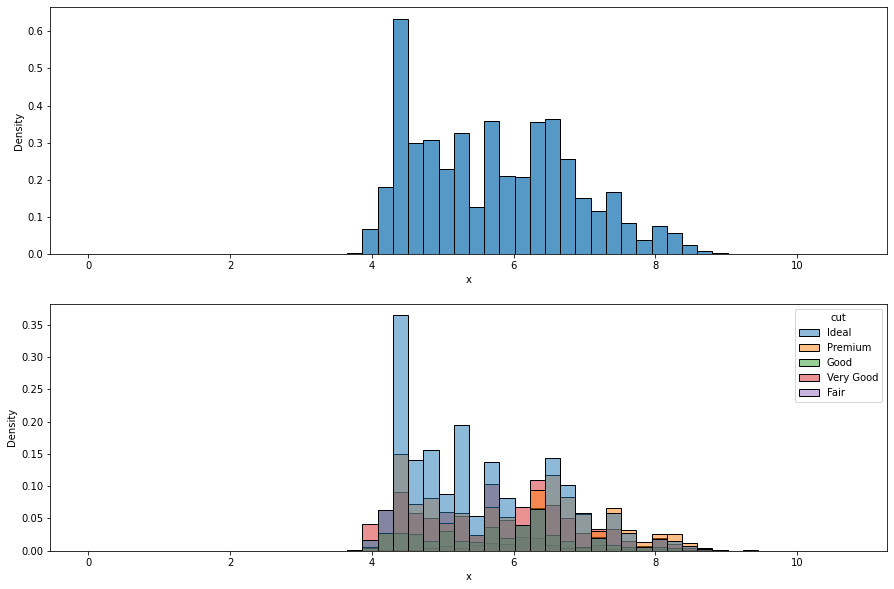

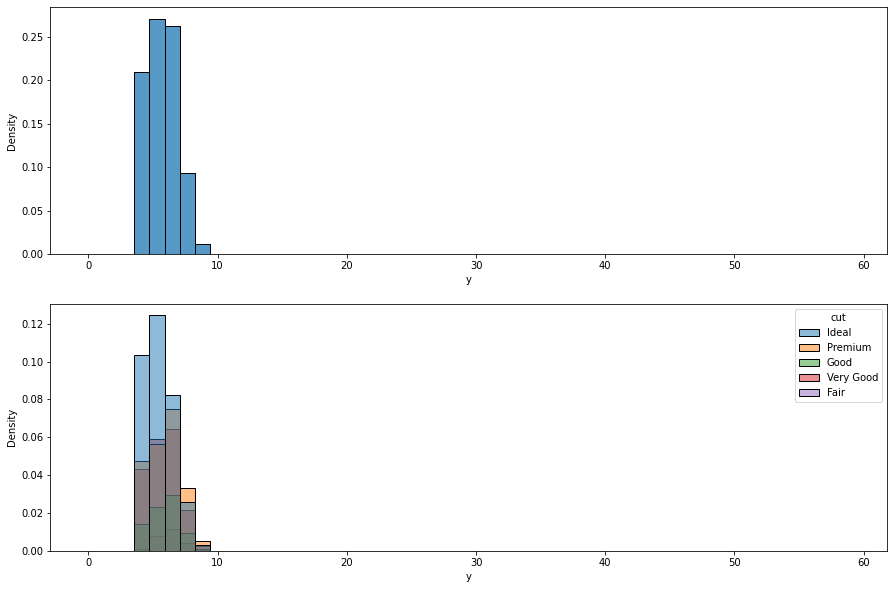

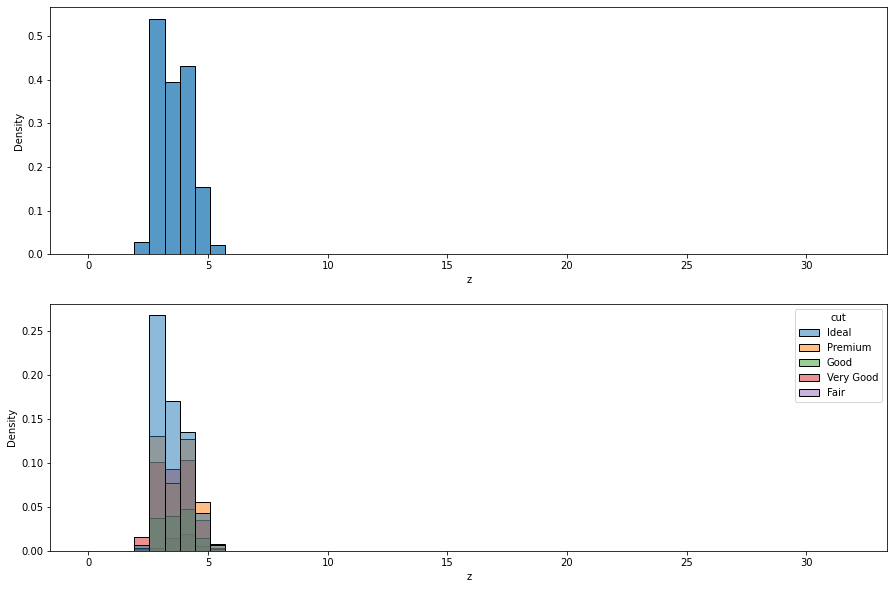

In [21]:
for col in diamonds[flt].columns:
    fig, ax = plt.subplots(2, figsize=(15, 10))
    sns.histplot(ax = ax[0], data = diamonds, x = col, stat = 'density', bins = 50, common_norm=True)
    sns.histplot(ax = ax[1], data = diamonds, x = col, stat = 'density', bins = 50, hue = 'cut', common_norm=True)
    plt.show()

**d)** Make a figure containing a matrix of subplots. These will present projections of the dataset onto each pair of features, histogram of their distributions and values of Pearson correlation coefficients.
- The upper triangular section of the matrix will contain in the (𝑖, 𝑗) entry the Pearson correlation between feature 𝑖 and feature 𝑗;
- The main diagonal will contain in position (𝑖, 𝑖) the histograms of the values of feature 𝑖. These histograms are the same as you already plotted in point c): you should use a different colour for each class and histograms should have 50 bins and should be normalized (the area under the histogram should sum up to 1);
- The lower triangular section of the matrix will contain in the (𝑖, 𝑗) entry the projections of the points onto the 𝑖 and j features. Use a different colour for each class and the colours should match those used in the histograms.

In [22]:
flt = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut'] # list of columns to plot

In [23]:
def correlation(x, y, hue = None, **kwargs):
    corr = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.text(0.5, 0.5, f'r = {corr:.2f}', size = 12, transform = ax.transAxes)
    ax.set_axis_off()

Adding the **hue** parameter to the plot would throw me an error that I could not figure out what it meant - *No values to concatenate*. Thus, the plots below have no hue parameter. My idea was to set the hue inside the map_diag and map_lower methods, but that was exactly what gave me the error. When I tried to set the hue parameter on the PairGrid method, then the hue would work, but would also override the correlation coefficients (of course, an expected behaviour). When I tried to do that and also set the hue parameter to None inside the map_upper method, it would just ignore my command and still override the correlation coefficients.

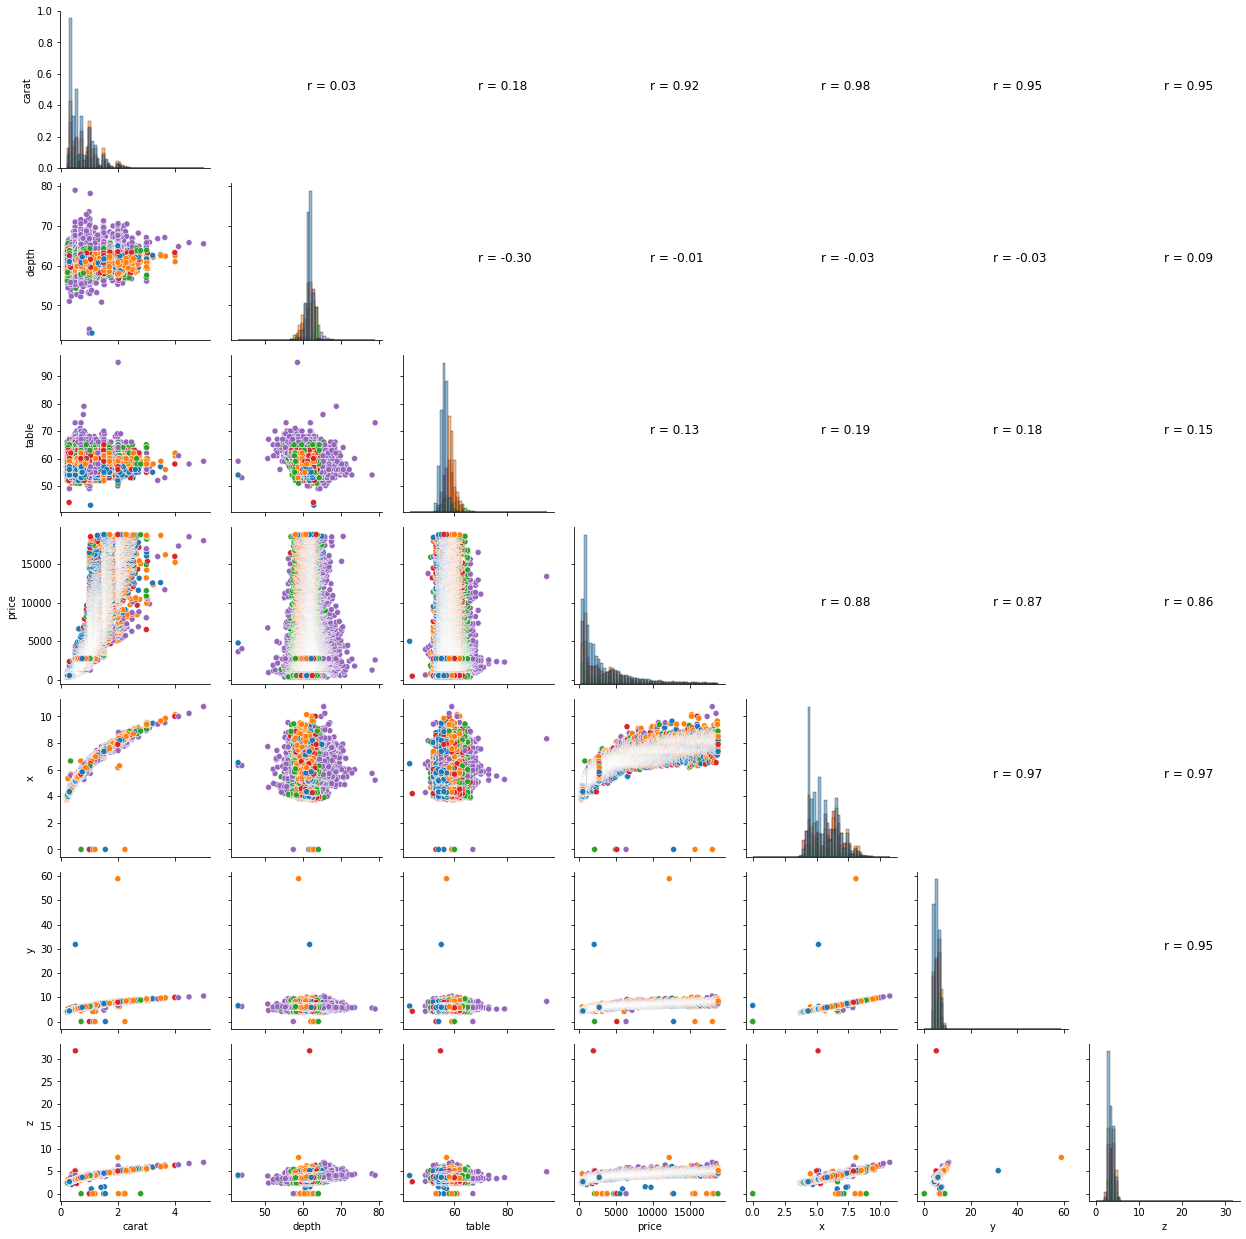

In [24]:
matrix = sns.PairGrid(diamonds[flt], diag_sharey=False, hue = 'cut')

matrix.map_diag(sns.histplot, bins=50, common_norm=True, stat = 'density')
matrix.map_upper(correlation)
matrix.map_lower(sns.scatterplot)

### **Part 2**: K-nearest-neighbour classifier

**a)** Split the dataset into training, validation and testing sets.

In [25]:
features = [c for c in diamonds.columns if c not in ['color', 'clarity']]

In [26]:
X_train, y_train, X_validation, y_validation, X_test, y_test = train_valid_test_split(diamonds[features], target = 'cut',
                                                                                      train_size = 0.70,
                                                                                      test_size = 0.20,
                                                                                      valid_size = 0.10)

**b)** Implement the scikit-learn estimator API for a K-nearest-neighbour classifier. Your estimator API will implement the Euclidean distance. Your estimator will accept the following parameters:
- **k**: This parameter controls the number of neighbours to consider. Set the default value to 5;
- **distances**: This parameter allows the user to precalculate distances for the datapoints, overriding the default (Euclidean) distance that you have implemented. The values passed to this parameter can be either a matrix of pairwise similarities, or the string “euclidean”. If the string “euclidean” is received, the estimator will calculate the distances; otherwise, no distances will be calculated, and the matrix that is being passed as a parameter will be used. Note that if the size of the matrix is not compatible with the number of datapoints, your estimator must raise an Exception.

In [27]:
class kNN(BaseEstimator):
    
    def __init__(self, k = 5, distances = 'euclidean'):
        self.k = k
        self.distances = distances
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predicted_labels = np.array([self.aux_predict(x) for x in X])
        return predicted_labels
    
    def aux_predict(self, x):
        
        if self.distances == 'euclidean':
            
            distances = np.linalg.norm(x - self.X_train, axis = 1) 
            k_nearest = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest]  
            mode = stats.mode(k_nearest_labels)[0][0]
        
        elif self.distances.shape[1] == self.X_train.shape[1]:
            
            k_nearest = np.argsort(self.distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest]
            mode = stats.mode(k_nearest_labels)[0][0]
                   
        else:
            raise Exception("Your training set and matrix of distances have different number of features")          
            
        return mode

**c)** Using your implementation of KNN, select the set of 3 numerical features that predict the “cut” variable with the best **ACCURACY** score on the validation set for each of the following different values of K: 2, 5, 10, and 15.

In [28]:
numerical_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
combinations = [list(c) for c in itertools.combinations(numerical_features, 3)]
possible_k = [2, 5, 10, 15]

info = []

for combination in combinations:
    for k in possible_k:
        kNN_obj = kNN(k = k, distances = 'euclidean') 
        kNN_obj.fit(X_train[combination].to_numpy(), y_train.to_numpy())
        predictions = kNN_obj.predict(X_validation[combination].to_numpy())
        acc = np.sum(predictions == y_validation)/len(y_validation)
        info.append([k, ', '.join(combination), acc])

In [29]:
accuracies = pd.DataFrame(info, columns = ['k', 'features', 'accuracy'])

**d)** Make a barplot of the accuracy on the validation set obtained by each set of 3 numerical features for the different values of k, highlighting in a different color the bars with the best accuracy. The figure should look like Figure 3 (with different values, as in the Figure I randomized the data and feature names to avoid giving away the solution)

Text(0.5, 1.0, 'k = 15')

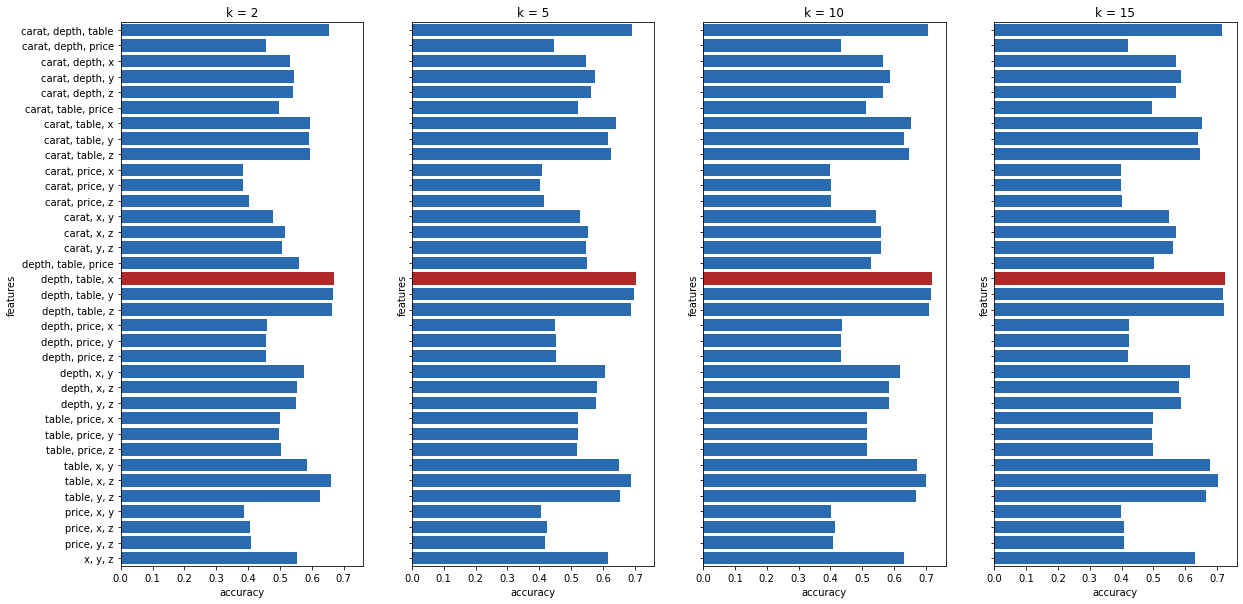

In [30]:
fig, (ax2, ax5, ax10, ax15) = plt.subplots(1, 4, figsize=(20, 10), sharex = True, sharey=True)

color = []
for acc in accuracies[accuracies['k'] == 2]['accuracy']:
    if acc == accuracies[accuracies['k'] == 2]['accuracy'].max():
        color.append('#c61212')
    else: 
        color.append('#1269c6')

sns.barplot(x='accuracy', y='features', data=accuracies[accuracies.k == 2], palette=color, ax = ax2)
ax2.set_title('k = 2')


color = []
for acc in accuracies[accuracies['k'] == 5]['accuracy']:
    if acc == accuracies[accuracies['k'] == 5]['accuracy'].max():
        color.append('#c61212')
    else: 
        color.append('#1269c6')
        
sns.barplot(x='accuracy', y='features', data=accuracies[accuracies.k == 5], palette=color, ax = ax5)
ax5.set_title('k = 5')


color = []
for acc in accuracies[accuracies['k'] == 10]['accuracy']:
    if acc == accuracies[accuracies['k'] == 10]['accuracy'].max():
        color.append('#c61212')
    else: 
        color.append('#1269c6')
        
sns.barplot(x='accuracy', y='features', data=accuracies[accuracies.k == 10], palette=color, ax = ax10)
ax10.set_title('k = 10')


color = []
for acc in accuracies[accuracies['k'] == 15]['accuracy']:
    if acc == accuracies[accuracies['k'] == 15]['accuracy'].max():
        color.append('#c61212')
    else: 
        color.append('#1269c6')
        
sns.barplot(x='accuracy', y='features', data=accuracies[accuracies.k == 15], palette=color, ax = ax15)
ax15.set_title('k = 15')

### **Part 3**: Linear Regression

Use the dataset you loaded in Part 1 with the dataset splits from Part 2. You will implement two different solutions for **linear regression with weight decay regularization**:
- Using the closed form (normal equations with weight decay);
- Using stochastic gradient descent.

Your implementation will predict the value of the “price” variable using all the remaining numerical features. It will consist of a scikit-learn estimator API with the following parameters:

- **solver:** This parameter selects which algorithm is used to learn the coefficients of the linear regression. Passing “cf” will select the closed form solution, passing “sgd” will select the stochastic gradient descent. Set the default value to “cf”;

- **max_iter:** This parameter is relevant only when the solver is “sgd”. It controls the number of iterations (over the entire dataset) of the stochastic gradient descent algorithm. Set the default value to 100;

- **learning_rate:** This parameter is relevant only when the solver is “sgd”. Set the default value to 0.0001.

In [32]:
features = [c for c in X_train.columns if c not in ['price']]

In [33]:
y_train_price = X_train['price']
y_validation_price = X_validation['price']
y_test_price = X_test['price']

X_train_price = X_train[features]
X_validation_price = X_validation[features]
X_test_price = X_test[features]

In [34]:
X_train_price_np = X_train_price.to_numpy()
X_test_price_np = X_test_price.to_numpy()
X_validation_price_np = X_validation_price.to_numpy()

y_train_price_np = y_train_price.to_numpy()
y_test_price_np = y_test_price.to_numpy()
y_validation_price_np = y_validation_price.to_numpy()

In [35]:

class LinearRegression(BaseEstimator):
    
    def __init__(self, solver = 'cf', max_iter = 100, learning_rate = 0.0001):
        self.solver = solver
        self.max_iter = max_iter
        self.learning_rate = learning_rate
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        
        if self.solver == 'cf':
            
            w0 = np.ones((self.X_train.shape[0], 1))
            matrix = np.c_[w0, self.X_train]
            
            I = np.eye(matrix.shape[1])
            decay = 0.01
            
            w = np.linalg.inv(decay*I + matrix.T @ matrix) @ matrix.T @ self.y_train[:,np.newaxis]
            
            
            m = X.shape[0]
            prediction = np.c_[np.ones((m, 1)), X] @ w
    
        elif self.solver == 'sgd':
            
            m, n = self.X_train.shape
            w0 = np.ones((m, 1))
            matrix = np.c_[w0, self.X_train]
            
            w = np.random.normal(scale=0.001,size=(n+1, 1))
            
            for j in range(self.max_iter):
                for i in range(m):
                    w += self.learning_rate * (self.y_train[i] - matrix[[i]] @ w) * matrix[[i]].T
            
            testing_data = X.shape[0]
            prediction = np.c_[np.ones((testing_data, 1)), X] @ w
            
        return prediction

In [36]:
LinearRegression_cf = LinearRegression()
LinearRegression_cf.fit(X_train_price_np, y_train_price_np)
prediction = LinearRegression_cf.predict(X_validation_price_np)
MSE = np.power(mean_squared_error(y_validation_price_np, prediction), 0.5)

print(f'MSE for LinearRegression using Closed Form: {MSE}')
print(f'Prediction: {prediction}')

<class 'numpy.ndarray'>
MSE for LinearRegression using Closed Form: 1436.0881525150592
Prediction: [[7760.1233152 ]
 [  60.45540522]
 [ 910.18363881]
 ...
 [5250.38723954]
 [3056.77295851]
 [5998.05078047]]


In [37]:
LinearRegression_sgd = LinearRegression(solver = 'sgd')
LinearRegression_sgd.fit(X_train_price_np, y_train_price_np)
prediction = LinearRegression_sgd.predict(X_validation_price_np)
MSE = np.power(mean_squared_error(y_validation_price_np, prediction), 0.5)

print(f'SME for LinearRegression using Stochastic Gradient Descent: {MSE}')
print(f'Prediction: {prediction}')

SME for LinearRegression using Stochastic Gradient Descent: 1982.6772673145792
Prediction: [[ 6594.00194656]
 [-1207.60260535]
 [ -759.15391823]
 ...
 [ 4250.56635094]
 [ 1686.01945709]
 [ 4778.37324286]]


### **Part 4**: Model Comparison

Use the models from Part 2 and 3 for this exercise. You will compare the performance of your models against the performance of estimators from the scikit-learn library on the test set from Part 2.

1. For the classification problem (you developed the estimator in Part 2) you will use all the numerical features and predict the “cut”. The steps to implement are:

    **a.** Select 3 classifiers from the scikit-learn library (you can pick any classifier of your choice, including those not seen in class yet).

    **b.** For each model (your model as well as the scikit-learn ones), use the training and validation sets to choose the best hyperparameters.

    **c.** Combine the training and validation sets into a single set and use it to train the models with the chosen hyperparameters.

    **d.** Compare the performance of the different estimators using the accuracy score.

    **e.** Make a plot that shows this comparison (here you can use any type of plot you like, as long as the comparison is clear).


In [38]:
X = pd.concat([X_train, X_validation])
y = pd.concat([y_train, y_validation])

In [39]:
# My kNN

param_grid = [{'k': [2, 5, 10, 15]}]

kNN_mine = kNN()

grid_search = GridSearchCV(kNN_mine, param_grid, scoring = 'accuracy', cv = 2)

grid_search.fit(X, y)

best_parameters_kNN_mine = grid_search.best_params_
best_parameters_kNN_mine

{'k': 2}

In [40]:
kNN_test = kNN(k = 2)

kNN_test.fit(X.to_numpy(), y.to_numpy())
predictions = kNN_test.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list_kNN_test = ['my kNN', acc]

In [49]:
# kNN from scikit-learn

param_grid = [{'n_neighbors': [2, 5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]

kNN = KNeighborsClassifier()

grid_search = GridSearchCV(kNN, param_grid, scoring = 'accuracy', cv = 2)

grid_search.fit(X, y)

best_parameters_kNN = grid_search.best_params_
best_parameters_kNN

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

In [43]:
kNN_skl = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', algorithm = 'auto')

kNN_skl.fit(X.to_numpy(), y.to_numpy())
predictions = kNN_skl.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list_kNN_skl = ['kNN skl', acc]

In [45]:
param_grid = [{'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 100000, 1000000]}]

GaussianNB_1 = GaussianNB()

grid_search = GridSearchCV(GaussianNB_1, param_grid, scoring = 'accuracy', cv = 2)

grid_search.fit(X, y)

best_parameters_GaussianNB = grid_search.best_params_
best_parameters_GaussianNB

{'var_smoothing': 1e-08}

In [46]:
GaussianNB_test = GaussianNB(var_smoothing = 1e-8)

GaussianNB_test.fit(X.to_numpy(), y.to_numpy())
predictions = GaussianNB_test.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list_GaussianNB_test = ['GaussianNB', acc]

In [50]:
param_grid = [{'n_estimators': [50, 100, 200], 'learning_rate': [0.6, 0.7, 0.8, 0.9, 1.0], 
               'algorithm': ['SAMME', 'SAMME.R']}]

AdaBoostClassifier_1 = AdaBoostClassifier()

grid_search = GridSearchCV(AdaBoostClassifier_1, param_grid, scoring = 'accuracy', cv = 2)

grid_search.fit(X, y)

best_parameters_AdaBoostClassifier = grid_search.best_params_
best_parameters_AdaBoostClassifier

{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}

In [51]:
AdaBoostClassifier_test = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.9, algorithm = 'SAMME')

AdaBoostClassifier_test.fit(X.to_numpy(), y.to_numpy())
predictions = AdaBoostClassifier_test.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list_AdaBoostClassifier_test = ['AdaBoostClassifier', acc]

In [52]:
list_total = [list_kNN_test, list_kNN_skl, list_GaussianNB_test, list_AdaBoostClassifier_test]
df = pd.DataFrame(list_total, columns = ['Model', 'Accuracy'])

<AxesSubplot:xlabel='Model', ylabel='Accuracy'>

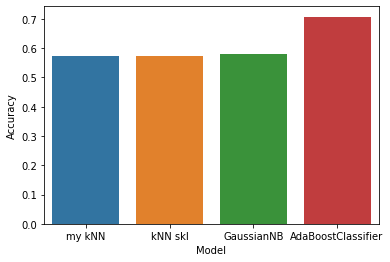

In [53]:
sns.barplot(x = 'Model', y = 'Accuracy', data = df)

2. For the regression problem (you developed the estimator in Part 2) you will predict the “price” using the remaining numerical features. The steps to implement are:
    
    **a.** Select 3 regressors from the scikit-learn library (you can pick any regressor of your choice, including those not seen in class yet).
    
    **b.** For each model (your model as well as the scikit-learn ones), use the training and validation sets to choose the best hyperparameters.

    **c.** Combine the training and validation sets into a single set and use it to train the models with the chosen hyperparameters.
    
    **d.** Compare the performance of the different estimators using the Root Mean Square Error score.

    **e.** Make a plot that shows this comparison (here you can use any type of plot you like, as long as the comparison is clear)

In [54]:
X_price = pd.concat([X_train_price, X_validation_price])
y_price = pd.concat([y_train_price, y_validation_price])

In [55]:
param_grid = [{'max_iter': [100, 200, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'solver': ['cf', 'sgd']}]

LinearRegression_1 = LinearRegression()

grid_search = GridSearchCV(LinearRegression_1, param_grid, scoring = 'neg_root_mean_squared_error', cv = 2)

grid_search.fit(X_price, y_price)

best_parameters_LinearRegression = grid_search.best_params_
best_parameters_LinearRegression

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


{'learning_rate': 0.0001, 'max_iter': 100, 'solver': 'cf'}

In [56]:
param_grid = [{'max_iter': [500], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 'penalty': ['l1', 'l2'], 'eta0': [0.01, 0.1, 0.5, 1.0]}]

SGD = SGDRegressor()

grid_search = GridSearchCV(SGD, param_grid, scoring = 'neg_root_mean_squared_error', cv = 2)

grid_search.fit(X_price, y_price)

best_parameters_SGD = grid_search.best_params_
best_parameters_SGD

{'eta0': 0.01, 'learning_rate': 'invscaling', 'max_iter': 500, 'penalty': 'l1'}

In [57]:
param_grid = [{'max_iter': [500], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.001, 0.01, 0.1]}]

ElasticNet = ElasticNet()

grid_search = GridSearchCV(ElasticNet, param_grid, scoring = 'neg_root_mean_squared_error', cv = 2)

grid_search.fit(X_price, y_price)

best_parameters_ElasticNet = grid_search.best_params_
best_parameters_ElasticNet

{'alpha': 0.0001, 'l1_ratio': 0.1, 'max_iter': 500}

In [58]:
param_grid = [{'max_iter': [500], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0], 'tol': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]}]

Lasso = Lasso()

grid_search = GridSearchCV(Lasso, param_grid, scoring = 'neg_root_mean_squared_error', cv = 2)

grid_search.fit(X_price, y_price)

best_parameters_Lasso = grid_search.best_params_
best_parameters_Lasso

{'alpha': 0.0001, 'max_iter': 500, 'tol': 0.001}